Let's give Conifer another chance, this time with the trimmed data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
import glob
ped_files = ['/data/sudregp/multiplex_simplex/simplex.ped']
wes_prefix = ['CLIA', 'CCGO', 'WPS']
# fid = open('/home/sudregp/data/multiplex_simplex/samples_simplex_all.txt', 'r')
# exclude_list = [line.rstrip() for line in fid]
# fid.close()

# no controls/affected pair for comparison
exclude_list = ['CLIA_400165', 'CLIA_400164', 'CLIA_400155', 'CLIA_400146',
                'CLIA_400145', 'CLIA_400126', 'CLIA_400207', 'CLIA_400208',
                'CLIA_400209']
# missing one parent
exclude_list += ['CLIA_400169', 'CLIA_400168']
# family 9030
exclude_list += ['CCGO_800978', 'CCGO_800977', 'CCGO_800976', 'CCGO_800979',
                 'CCGO_800980', 'CLIA_400067']

trios = []
affected = []
controls = []
samples = []
famids = []
for ped_file in ped_files:
    fid = open(ped_file, 'r')
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        # if the current ID and its parents have WES data, and the sample is 
        # not in yet
        if (fa.split('_')[0] in wes_prefix and
            mo.split('_')[0] in wes_prefix and
            sid.split('_')[0] in wes_prefix and
            sid not in samples and
            (sid not in exclude_list or fa not in exclude_list or mo not in exclude_list)):
            fam = {}
            fam['child'] = sid
            if aff == '1':
                affected.append(sid)
            else:
                controls.append(sid)
            fam['father'] = fa
            fam['mother'] = mo
            fam['famid'] = famid
            trios.append(fam)
            samples += [sid, fa, mo]
            famids.append(famid)
    fid.close()
samples = set(samples)
famids = set(famids)
kids = set(affected + controls)

print 'Unique samples:', len(samples)
print 'Unique families:', len(famids)
print 'Unique children:', len(kids)

Unique samples: 84
Unique families: 19
Unique children: 46


In [3]:
fid = open('/data/sudregp/cnv/trimmed/conifer/samples.txt', 'w')
for s in samples:
    fid.write(s + '\n')
fid.close()

fid = open('/data/sudregp/cnv/trimmed/conifer/kid_samples.txt', 'w')
for s in kids:
    fid.write(s + '\n')
fid.close()

In [ ]:
#  in terminal

cd ~/data/cnv/trimmed/conifer
mkdir RPKM
module load python
source activate my_py2.7

probes=/data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed

pip install --user pysam==0.8.3

while read s; do
    python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py rpkm \
        --probes $probes \
        --input ../BAM/${s}.bam \
        --output RPKM/${s}.rpkm.txt;
done < samples.txt

But this takes a while, so let's swarm itL

In [7]:
%%bash

cd ~/data/cnv/trimmed/conifer

rm swarm.rpkm

probes="/data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed"

cmd_str="source activate my_py2.7; cd ~/data/cnv/trimmed/conifer; "

while read s; do
    echo $cmd_str "python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py rpkm --probes $probes --input ../BAM/${s}.bam --output RPKM/${s}.rpkm.txt" >> swarm.rpkm;
done < samples.txt

swarm --partition quick -f swarm.rpkm --job-name rpkm --logdir trash --module python

In [ ]:
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py analyze \
    --probes $probes \
    --rpkm_dir ./RPKM/ --output analysis.hdf5 --svd 6 \
    --write_svals singular_values.txt --plot_scree screeplot.png \
    --write_sd sd_values.txt
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py call \
    --input analysis.hdf5 --output calls.txt

Let's do a quick run check of the results:

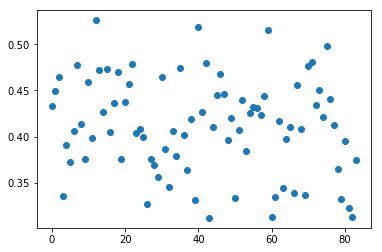

In [1]:
%matplotlib inline

import pylab as pl

fid = open('/data/sudregp/cnv/trimmed/conifer/sd_values.txt', 'r')
sds = [float(line.rstrip().split('\t')[1]) for line in fid]
fid.close()
pl.plot(sds, 'o')

Nothing looks too big, but let's quantify it:

In [3]:
import numpy as np
[s for s in sds if s > (np.mean(sds) + 3*np.std(sds)) or 
                   s < (np.mean(sds) - 3*np.std(sds)) ]

[]

All good. Let's explore the variance plot:

In [4]:
import pandas as pd

df = pd.read_table('/data/sudregp/cnv/conifer84/singular_values.txt',
                   header=None, index_col=0)
df.shape

(24, 84)

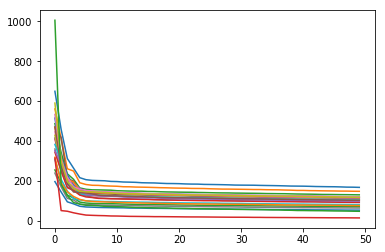

In [5]:
fig = pl.plot(range(50), np.array(df)[:, :50].T)

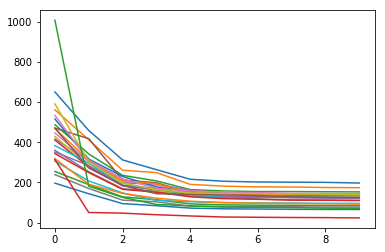

In [6]:
fig = pl.plot(range(10), np.array(df)[:, :10].T)

So, 4 should be enough to remove any noise. Let's re-run it:

In [ ]:
#  in terminal
cd ~/data/cnv/trimmed/conifer
module load python
source activate my_py2.7

probes=/data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py analyze \
    --probes $probes \
    --rpkm_dir ./RPKM/ --output analysis.hdf5 --svd 4 \
    --write_svals singular_values.txt --plot_scree screeplot.png \
    --write_sd sd_values.txt
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py call \
    --input analysis.hdf5 --output calls.txt